# 각 군집별 특성 파악
- 이제 각 군집별(0, 1)로 어떠한 특성을 보이는지 살펴보도록 하겠다.

**<Raw Data 변수 설명>**
1. date: 방송일시
2. exp_mins: 노출(분)
3. mom_code: 마더코드
4. pd_code: 상품코드
5. pd_name: 상품명
6. pd_group: 상품군
7. pd_price: 판매단가
8. sales: 취급액
    - 취급액 = 판매단가 x 주문량
9. weekdays: 요일
10. seasons: 계절
    - 1: 겨울(winter): 12 ~ 2월
    - 2: 봄(spring): 3 ~ 5월
    - 3: 여름(summer): 6 ~ 8월
    - 4: 가을(autumn): 9 ~ 11월
11. rating: 시청률
    - 단위는 "%"
    - exp_mins(노출(분))을 기준으로 평균 값을 계산
12. temp: 기온
13. rain: 강수량
14. humidity: 습도
15. snow: 적설량
16. dust: 미세먼지 농도
17. is_rain: 비 내림 여부
    - 0: 비 내리지 않음
    - 1: 비 내림
18. is_snow: 눈 내림 여부
    - 0: 눈 내리지 않음
    - 1: 눈 내림

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

# for문 진행 현황을 확인할 수 있는 패키지
from tqdm.notebook import tqdm

# 여러 개의 데이터 프레임을 한 번에 merge 해주기 위한 패키지
from functools import reduce

# 이 두 줄의 코드는 matplotlib의 기본 scheme말고, seaborn scheme을 세팅해준다
# 일일이 graph의 font size를 지정할 필요 없이, seaborn의 font_scale을 사용하면 편리하다
plt.style.use('seaborn')
sns.set(font_scale = 2.5)

# 그래프에서 한글 폰트 깨지는 문제를 해결해주기 위한 코드
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname = path).get_name()
    rc('font', family = font_name)
else:
    print('Unknown system... sorry~~~~')

In [2]:
clustered = pd.read_csv('C:/Users/82109/Desktop/Data Science/Competition/2020_Bigcontest_working/dataset/clustered.csv')
clustered.head()

,date,exp_mins,mom_code,pd_code,pd_name,pd_group,pd_price,sales,weekdays,seasons,...,dust,is_rain,is_snow,pd_count,month,day,hour,month_cat,hour_cat,cluster
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,Tuesday,1,...,65.0,0,0,53,1,1,6,상반기,오전,1
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,Tuesday,1,...,65.0,0,0,110,1,1,6,상반기,오전,1
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,Tuesday,1,...,65.0,0,0,82,1,1,6,상반기,오전,1
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,Tuesday,1,...,65.0,0,0,175,1,1,6,상반기,오전,1
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,Tuesday,1,...,65.0,0,0,168,1,1,6,상반기,오전,1


## 군집 정의

- 먼저 cluster가 "0"인 데이터 셋과 "1"인 데이터 셋으로 분할하겠다.

In [3]:
df_cluster_0 = clustered[clustered['cluster'] == 0]
df_cluster_1 = clustered[clustered['cluster'] == 1]

In [4]:
df_cluster_0.month.value_counts()

7     3345
8     3137
9     3127
10    3075
12    2984
11    2779
Name: month, dtype: int64

In [5]:
df_cluster_1.month.value_counts()

5    3559
4    3413
3    3248
6    3011
1    2881
2    2813
Name: month, dtype: int64

- 위 결과를 보면, 각 군집별로 존재하는 월(month)이 다르다.
    - cluster = 0 : 7 ~ 12월(하반기)
    - cluster = 1 : 1 ~ 6월(상반기)
- 다음으로 각 군집별로 판매량(pd_count)에 차이가 있는지 확인해보겠다.
    - 차이가 있다면 각 군집을 "판매량이 높은 군집"과 "판매량이 낮은 군집"으로 분류할 수 있기 때문!!

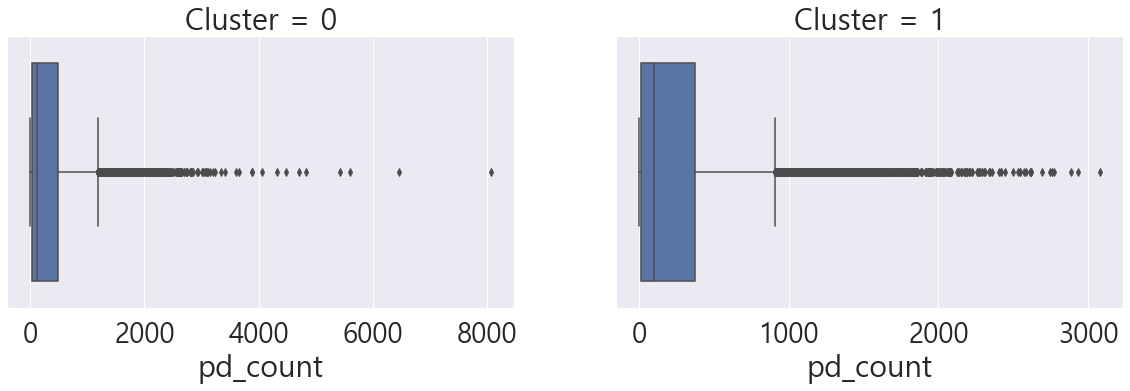

In [6]:
f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
f.set_size_inches(20, 5)

sns.boxplot(df_cluster_0['pd_count'], ax = ax1)
sns.boxplot(df_cluster_1['pd_count'], ax = ax2)

ax1.set_title('Cluster = 0')
ax2.set_title('Cluster = 1')

plt.show()

- 위 결과를 통해 **cluster = 0인 경우**를 **"판매량이 비교적 높은 군집"**, **cluster = 1인 경우**를 **"판매량이 비교적 낮은 군집"**으로 정의내릴 수 있어보인다.

## 각 군집별 탐색

In [7]:
clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37372 entries, 0 to 37371
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       37372 non-null  object 
 1   exp_mins   37372 non-null  float64
 2   mom_code   37372 non-null  int64  
 3   pd_code    37372 non-null  int64  
 4   pd_name    37372 non-null  object 
 5   pd_group   37372 non-null  object 
 6   pd_price   37372 non-null  int64  
 7   sales      37372 non-null  float64
 8   weekdays   37372 non-null  object 
 9   seasons    37372 non-null  int64  
 10  rating     37372 non-null  float64
 11  temp       37372 non-null  float64
 12  rain       3489 non-null   float64
 13  humidity   37372 non-null  float64
 14  snow       368 non-null    float64
 15  dust       37372 non-null  float64
 16  is_rain    37372 non-null  int64  
 17  is_snow    37372 non-null  int64  
 18  pd_count   37372 non-null  int64  
 19  month      37372 non-null  int64  
 20  day   

## 연속형 변수
- exp_mins
- pd_count
- rating
- temp
- humidity
- dust

### 각 군집별(cluster) 노출(분) 시간(exp_mins)

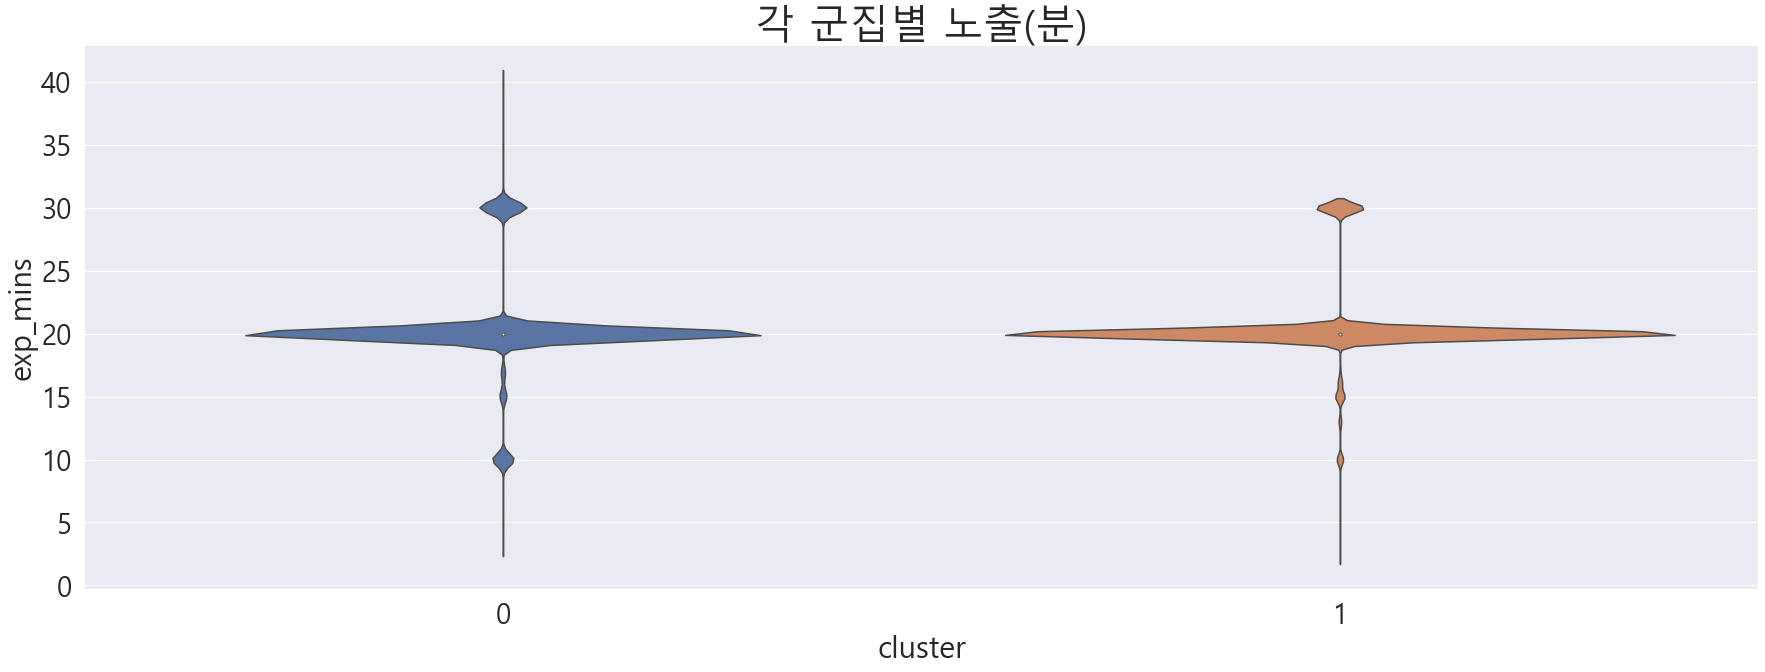

In [8]:
f, ax1 = plt.subplots(nrows = 1)
f.set_size_inches(30, 10)

sns.violinplot(data = clustered, x = 'cluster', y = 'exp_mins', ax = ax1)
ax1.set_title('각 군집별 노출(분)', fontsize = 40)
plt.show()

- 위 결과를 보면, 군집별 노출(분) 시간에는 큰 차이가 없어보인다.

**<각 군집별 월별/일별/시간대별/요일별/계절별 "연속형 변수"> 함수 생성**
- 여기서부터 그려볼 그래프는 동일한 코드를 사용하므로, 편리성을 위해 하나의 함수를 만들어서 사용하겠다.

In [9]:
def cluster_plots(y_var_eng, y_var_kor):
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 5)
    f.set_size_inches(50, 50)

    sns.pointplot(data = clustered, x = 'month', y = y_var_eng, hue = 'cluster', ax = ax1)
    sns.pointplot(data = clustered, x = 'day', y = y_var_eng, hue = 'cluster', ax = ax2)
    sns.pointplot(data = clustered, x = 'hour', y = y_var_eng, hue = 'cluster', ax = ax3)
    sns.pointplot(data = clustered, x = 'weekdays', y = y_var_eng, hue = 'cluster', ax = ax4)
    sns.pointplot(data = clustered, x = 'seasons', y = y_var_eng, hue = 'cluster', ax = ax5)

    ax1.set_title('각 군집별 월별 {}'.format(y_var_kor), fontsize = 40)
    ax2.set_title('각 군집별 일별 {}'.format(y_var_kor), fontsize = 40)
    ax3.set_title('각 군집별 시간대별 {}'.format(y_var_kor), fontsize = 40)
    ax4.set_title('각 군집별 요일별 {}'.format(y_var_kor), fontsize = 40)
    ax5.set_title('각 군집별 계절별 {}'.format(y_var_kor), fontsize = 40)

    # legend 위치 및 사이즈 조절
    axs = [ax1, ax2, ax3, ax4, ax5]
    for ax in axs:
        ax.legend(loc = 'center left', title = 'Cluster', frameon = True, 
                  bbox_to_anchor = (1, 0.5), title_fontsize = 30, fontsize = 30)

    plt.subplots_adjust(hspace = 0.6) # 각각의 subplot들이 겹치지 않도록 세로 공간을 조정
    plt.show()

### 각 군집별(cluster) 월별(month)/일별(day)/시간대별(hour)/요일별(weekdays)/계절별(seasons) 판매량(pd_count)

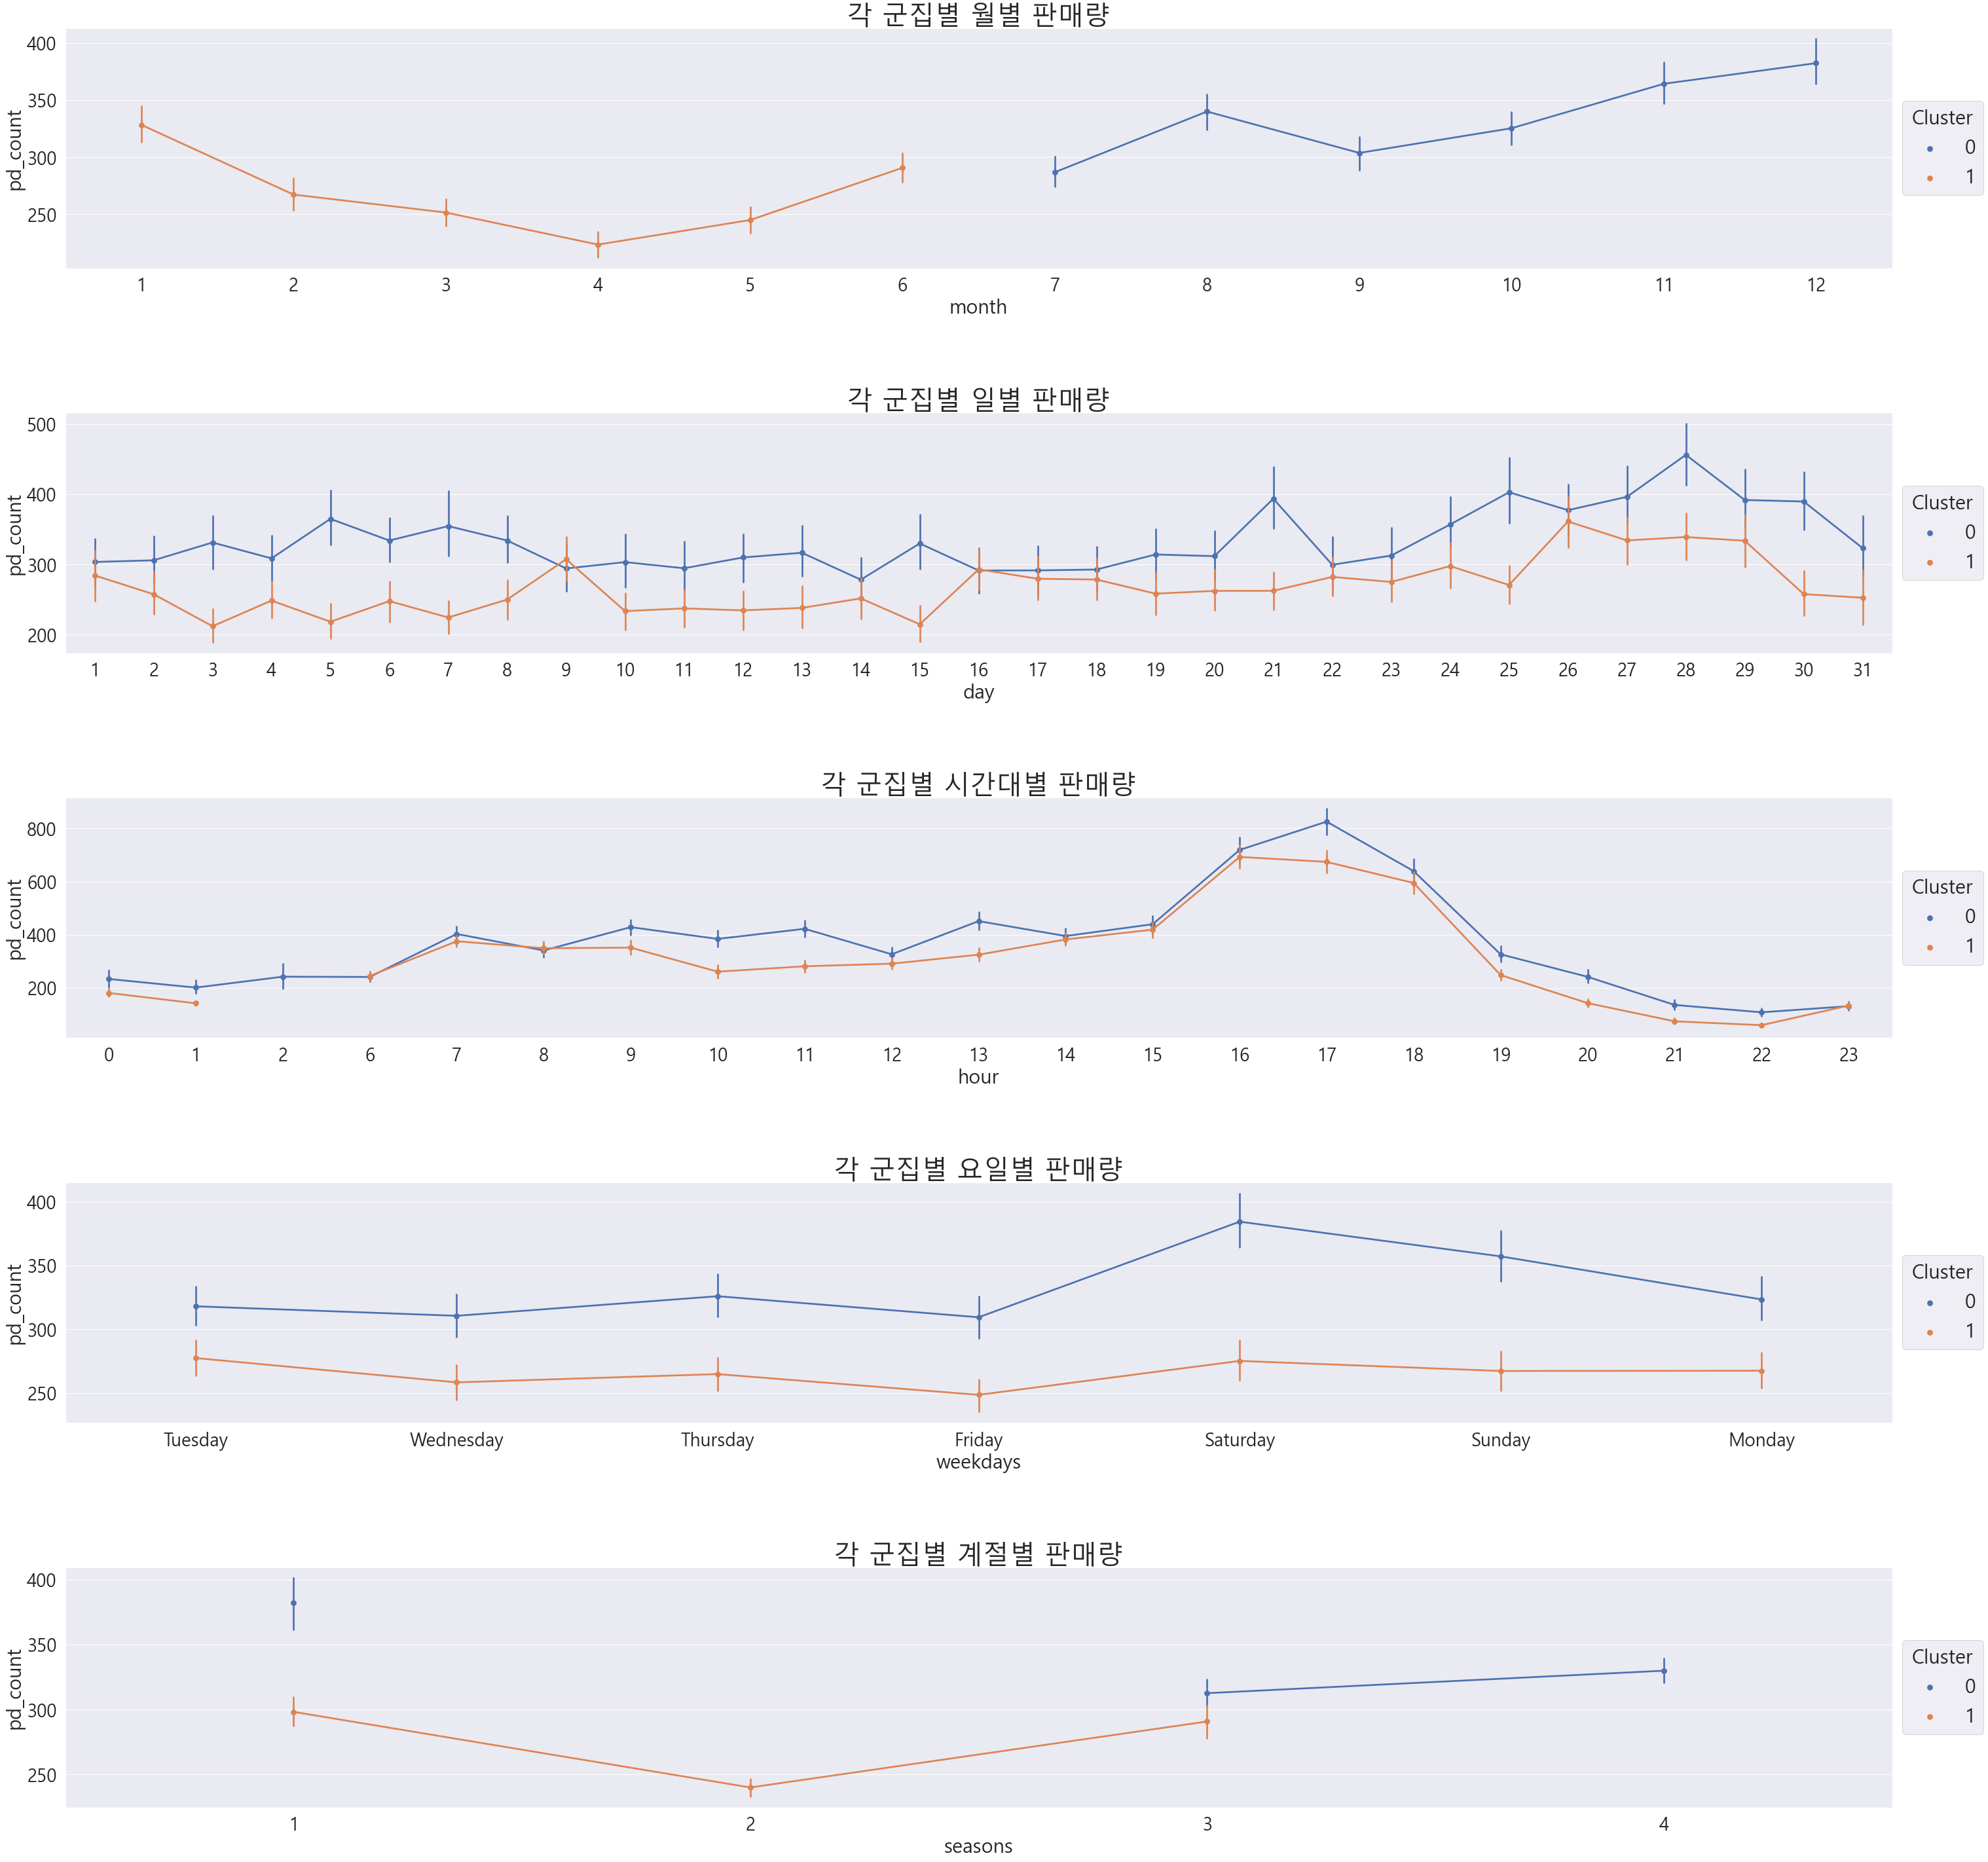

In [10]:
cluster_plots('pd_count', '판매량')

- 위 결과를 통해, 전반적으로 "상반기(1 ~ 6월)"보다 "하반기(7 ~ 12월)"에 판매량이 더 높은 것을 알 수 있다.

### 각 군집별(cluster) 월별(month)/일별(day)/시간대별(hour)/요일별(weekdays)/계절별(seasons) 시청률(rating)

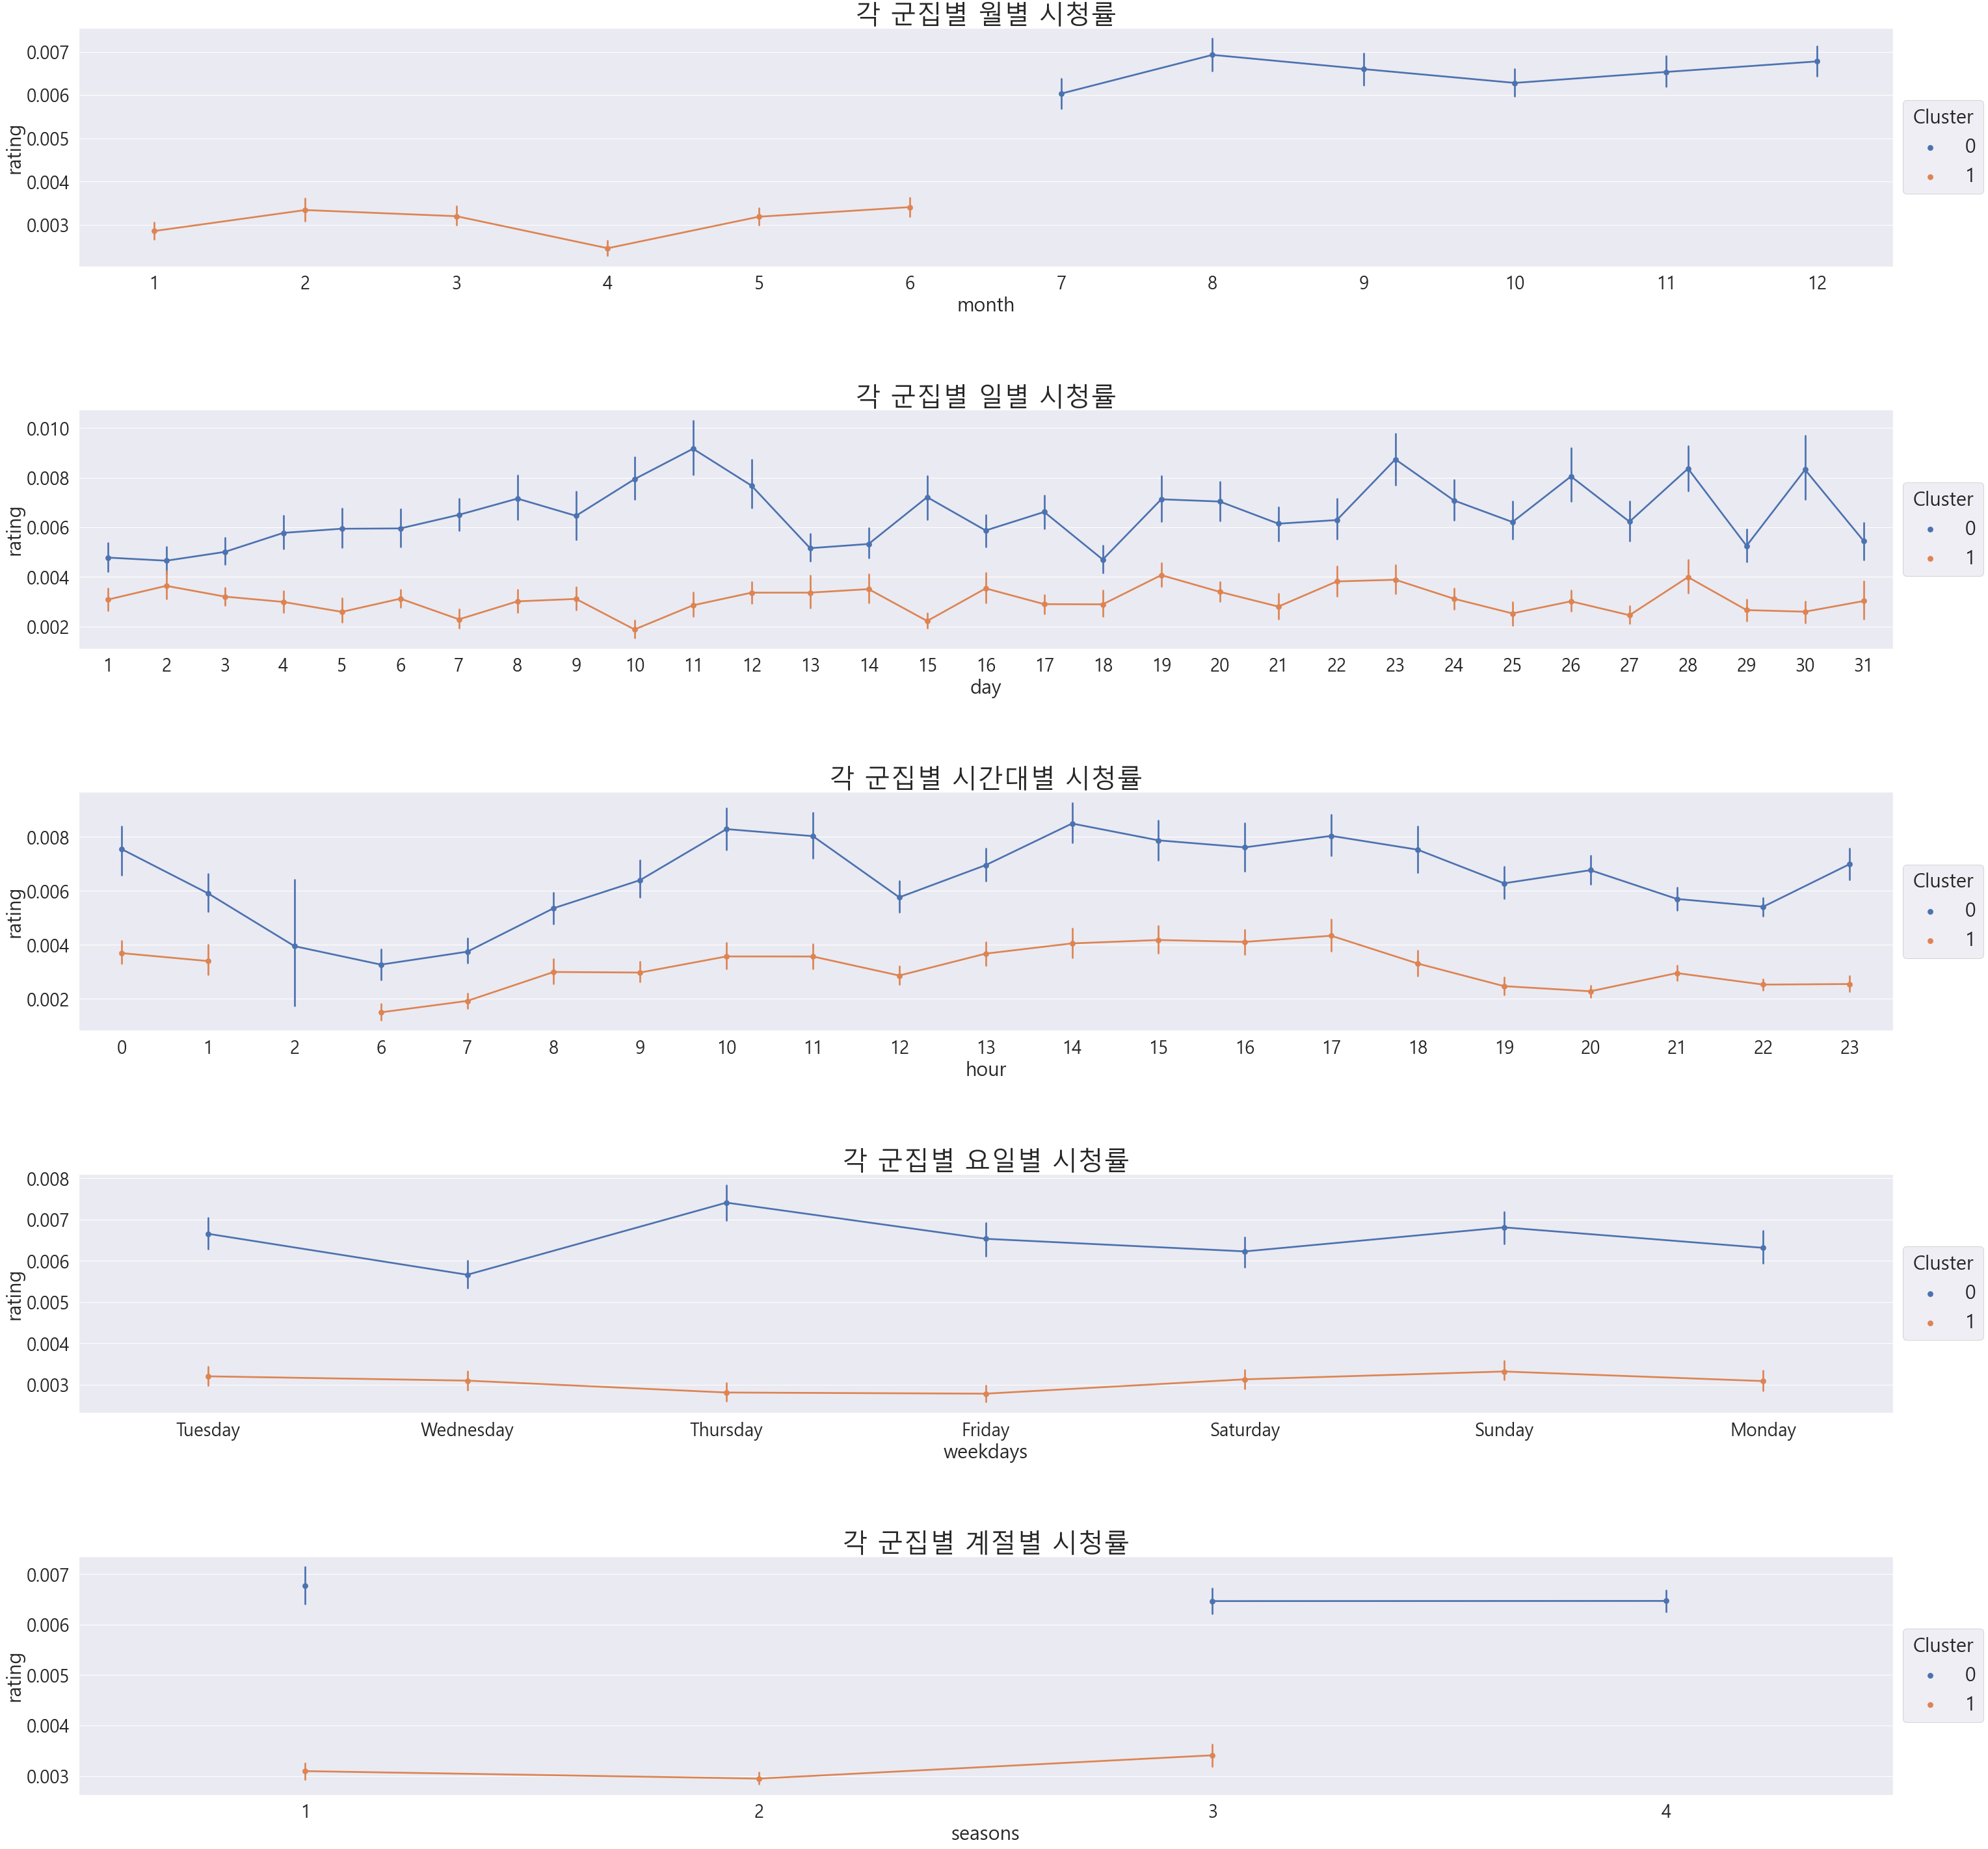

In [11]:
cluster_plots('rating', '시청률')

- 위 결과를 통해, 전반적으로 "상반기(1 ~ 6월)"보다 "하반기(7 ~ 12월)"에 시청률이 더 높은 것을 알 수 있다.
    - 이러한 결과로 보았을 때, cluster = 0인 군집은 판매량과 시청률이 모두 비교적 높고, cluster = 1인 군집은 판매량과 시청률이 모두 비교적 낮음을 알 수 있다.
        - 즉, "판매량(pd_count)"과 "시청률(rating)"은 서로 관련이 있어보인다.
        - 근데 왜 상관계수가 매우 낮게 나왔을까...(의문)
- 요약하면 **판매량이 높은 군집**은 **"하반기(7 ~ 12월) + 높은 시청률"**이라는 특징을 갖는다.

### 각 군집별(cluster) 기온(temp)/습도(humidity)/미세먼지 농도(dust)

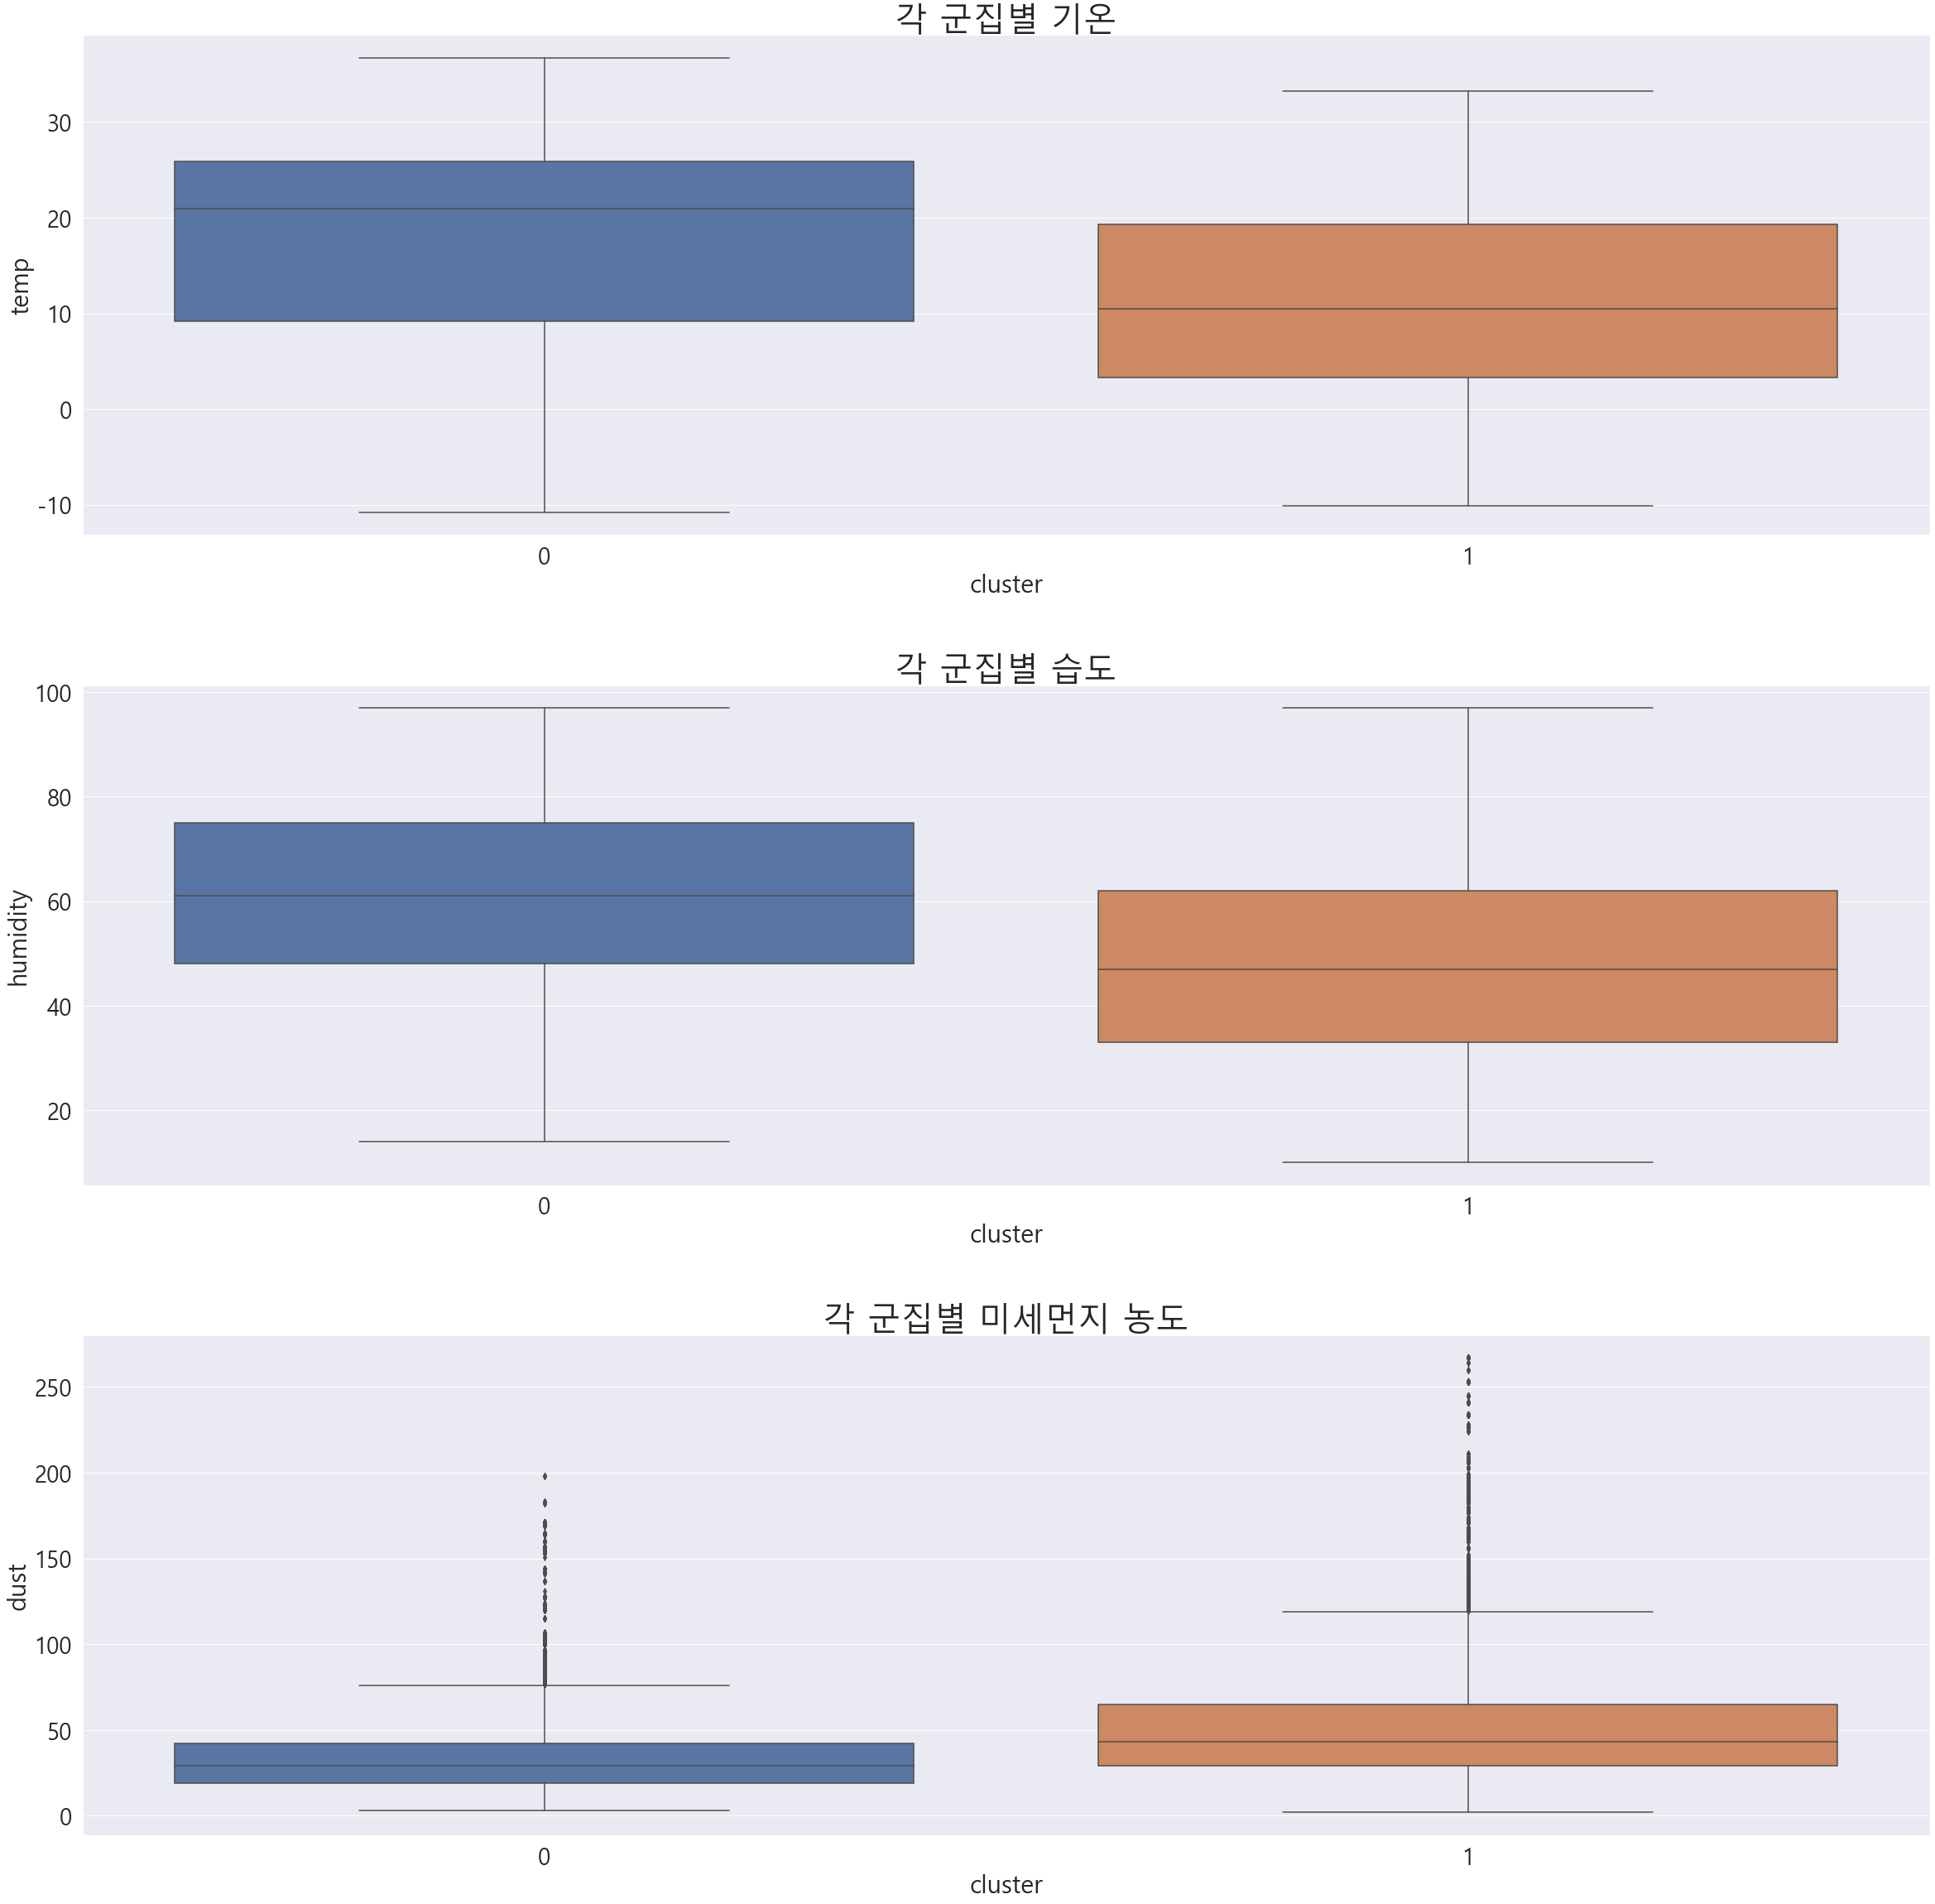

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(nrows = 3)
f.set_size_inches(40, 40)

# 1. 기온(temp)
sns.boxplot(data = clustered, x = 'cluster', y = 'temp', ax = ax1)
# 2. 습도(humidity)
sns.boxplot(data = clustered, x = 'cluster', y = 'humidity', ax = ax2)
# 3. 미세먼지 농도(dust)
sns.boxplot(data = clustered, x = 'cluster', y = 'dust', ax = ax3)

ax1.set_title('각 군집별 기온', fontsize = 40)
ax2.set_title('각 군집별 습도', fontsize = 40)
ax3.set_title('각 군집별 미세먼지 농도', fontsize = 40)

plt.subplots_adjust(hspace = 0.3) # 각각의 subplot들이 겹치지 않도록 세로 공간을 조정
plt.show()

### 각 군집별(cluster) 월별(month)/일별(day)/시간대별(hour)/요일별(weekdays)/계절별(seasons) 기온(temp)

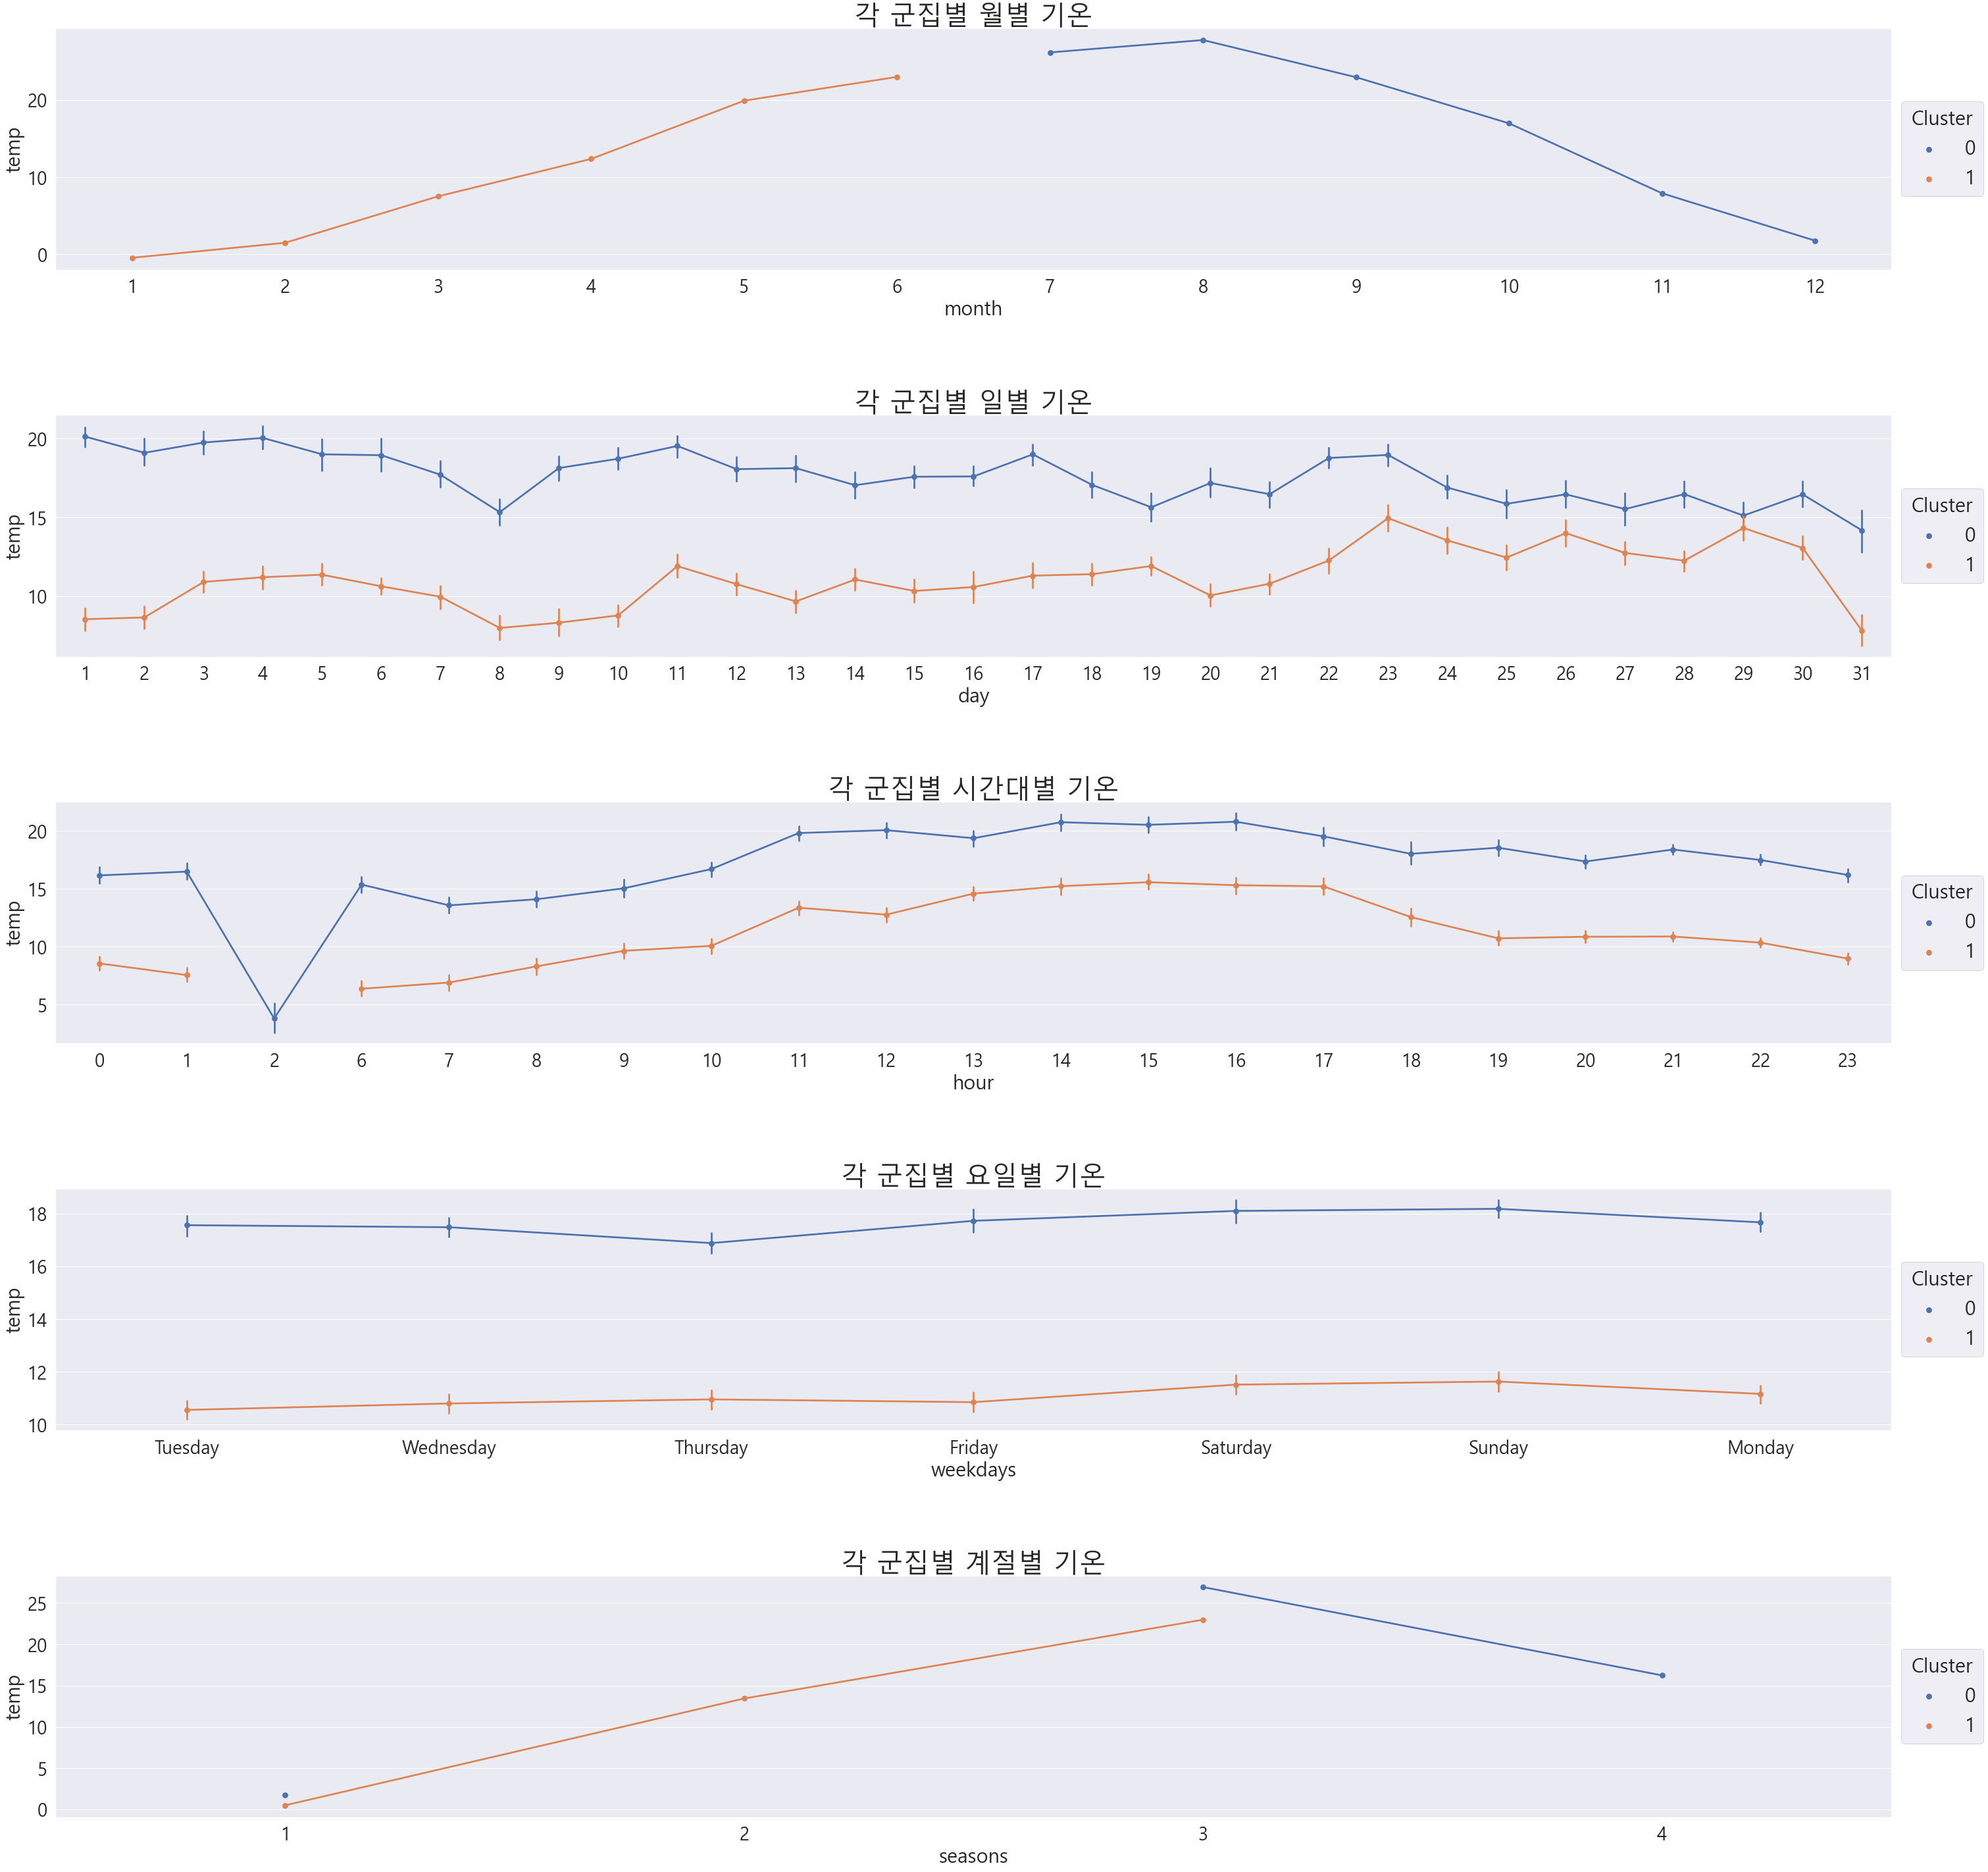

In [13]:
cluster_plots('temp', '기온')

- 전반적으로 판매량이 낮은 군집(1)보다 판매량이 높은 군집(0)의 기온이 더 높다.
    - 이걸 "기온이 높을수록 판매량이 높다"라고 볼 수 있나..?

### 각 군집별(cluster) 월별(month)/일별(day)/시간대별(hour)/요일별(weekdays)/계절별(seasons) 습도(humidity)

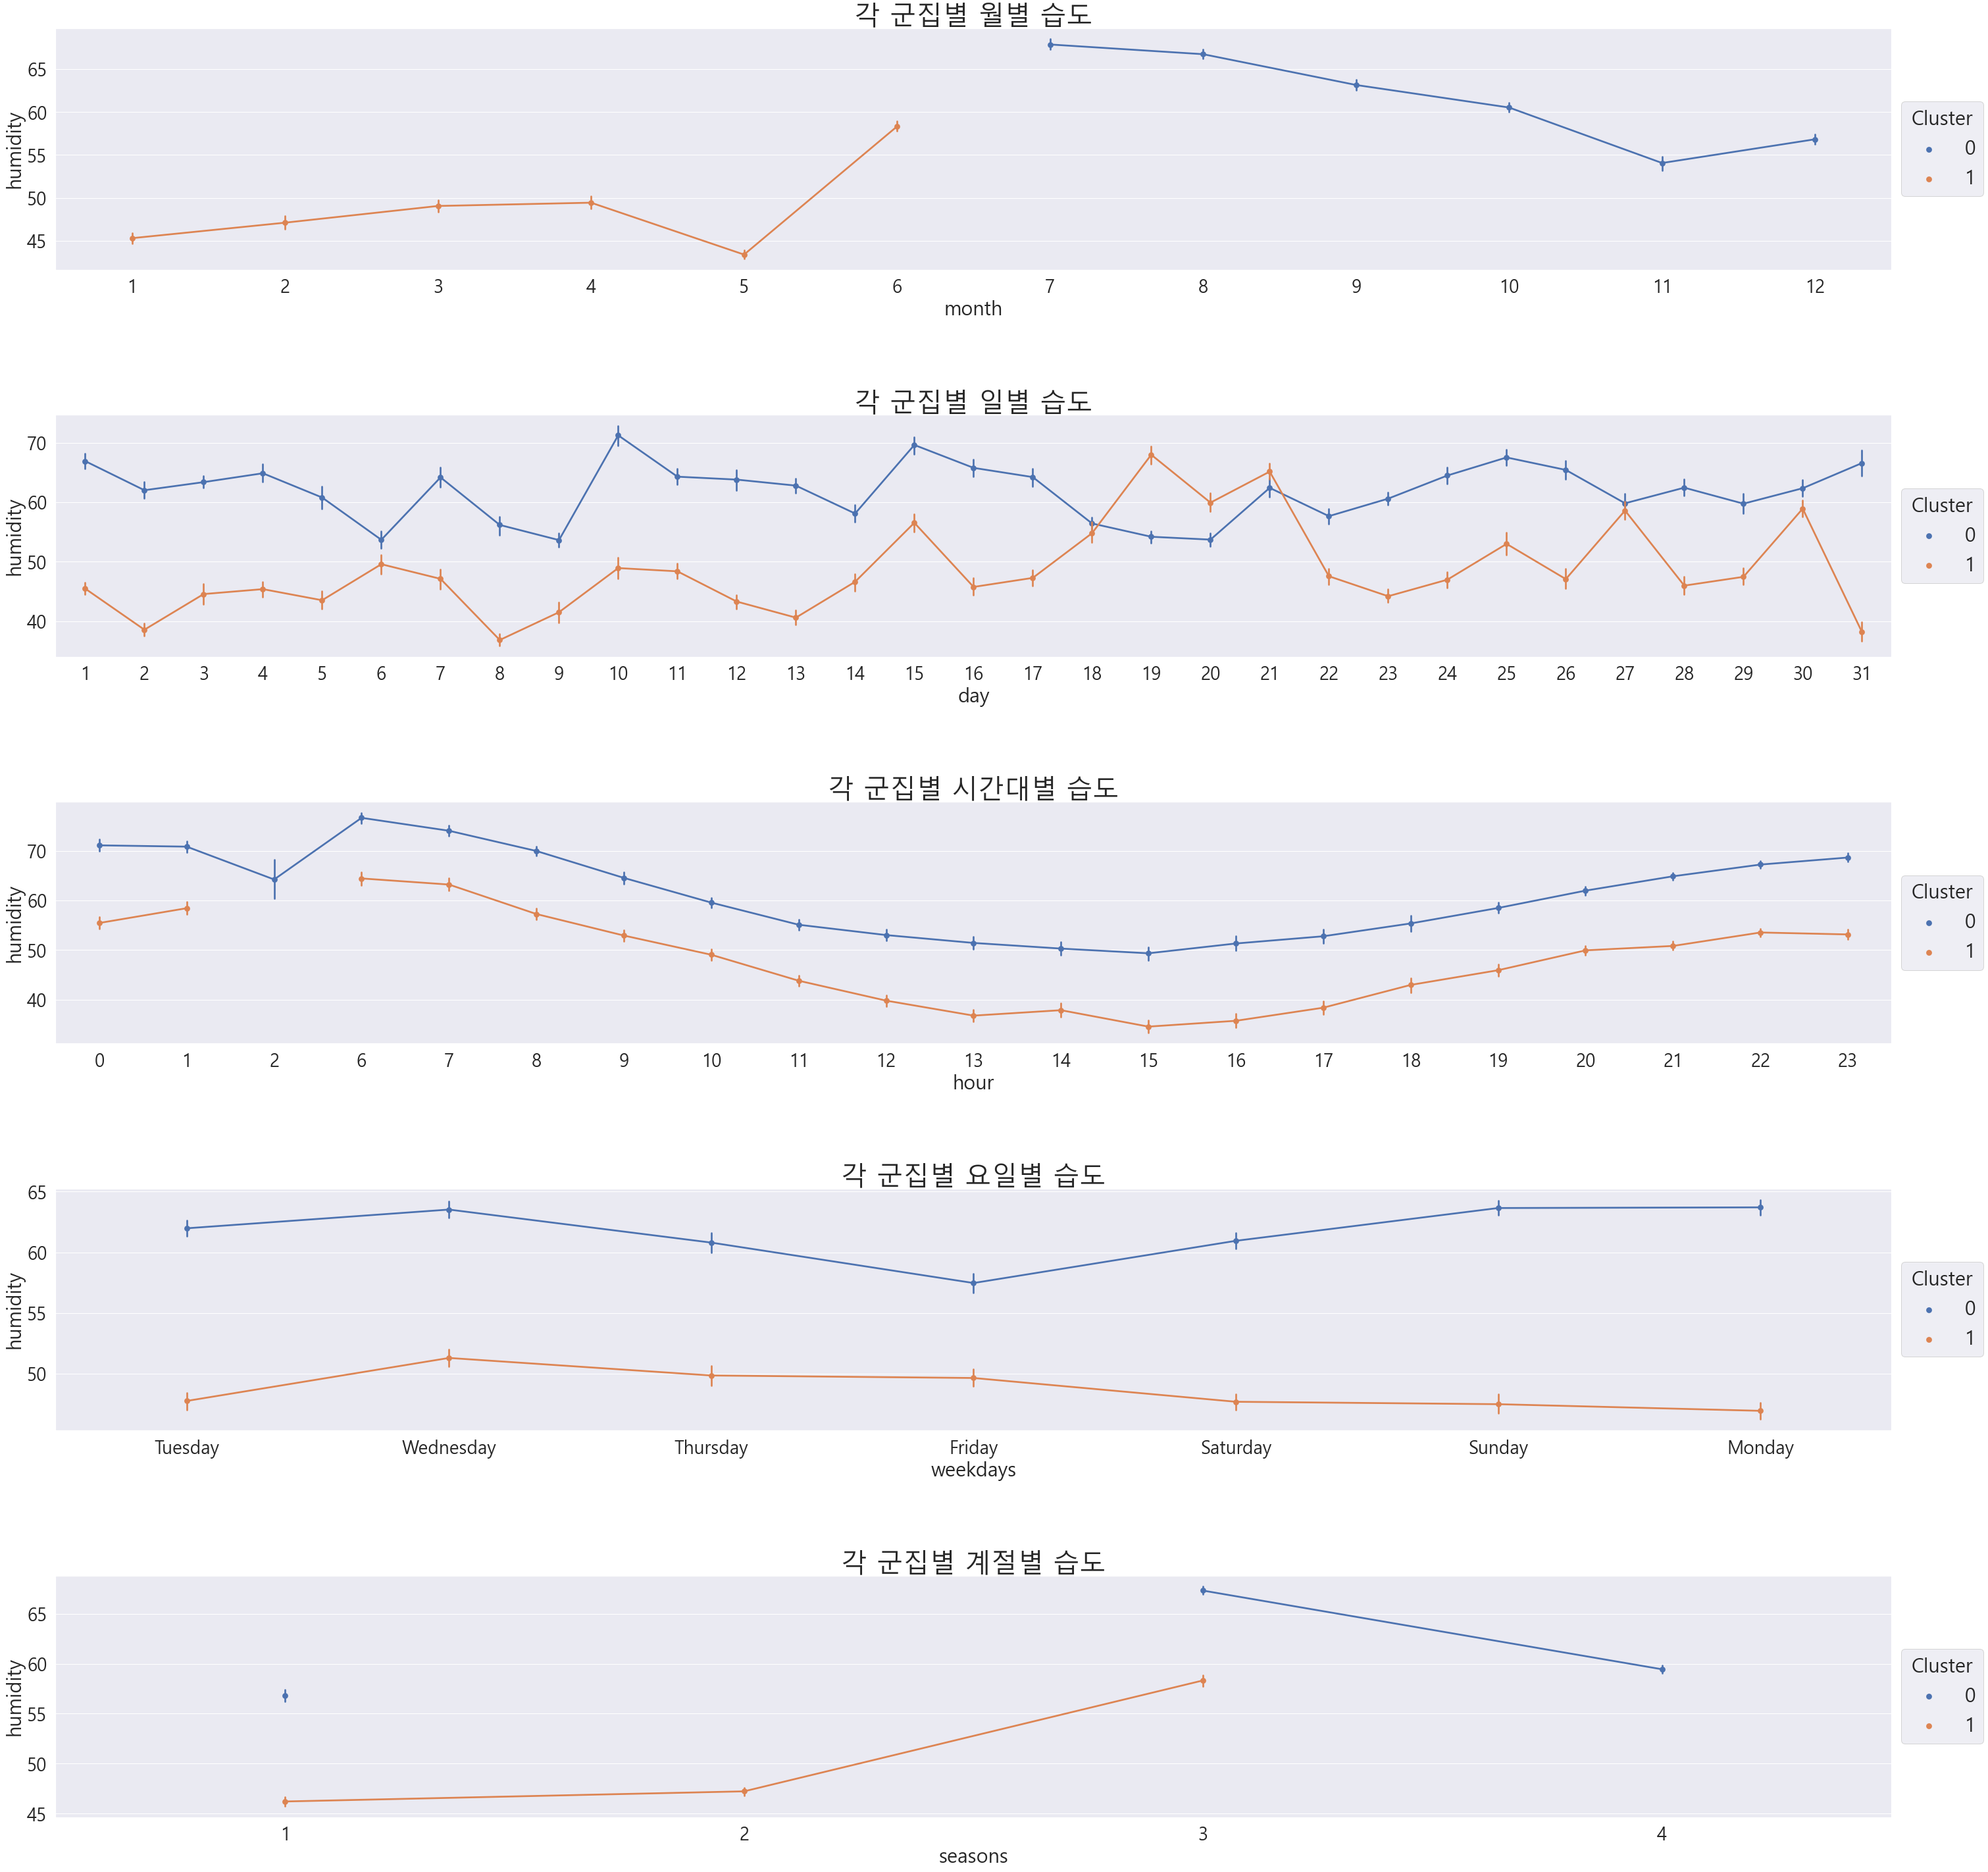

In [14]:
cluster_plots('humidity', '습도')

- 전반적으로 판매량이 낮은 군집(1)보다 판매량이 높은 군집(0)의 습도가 더 높다.
    - 이걸 "습도가 높을수록 판매량이 높다"라고 볼 수 있나..?

### 각 군집별(cluster) 월별(month)/일별(day)/시간대별(hour)/요일별(weekdays)/계절별(seasons) 미세먼지 농도(dust)

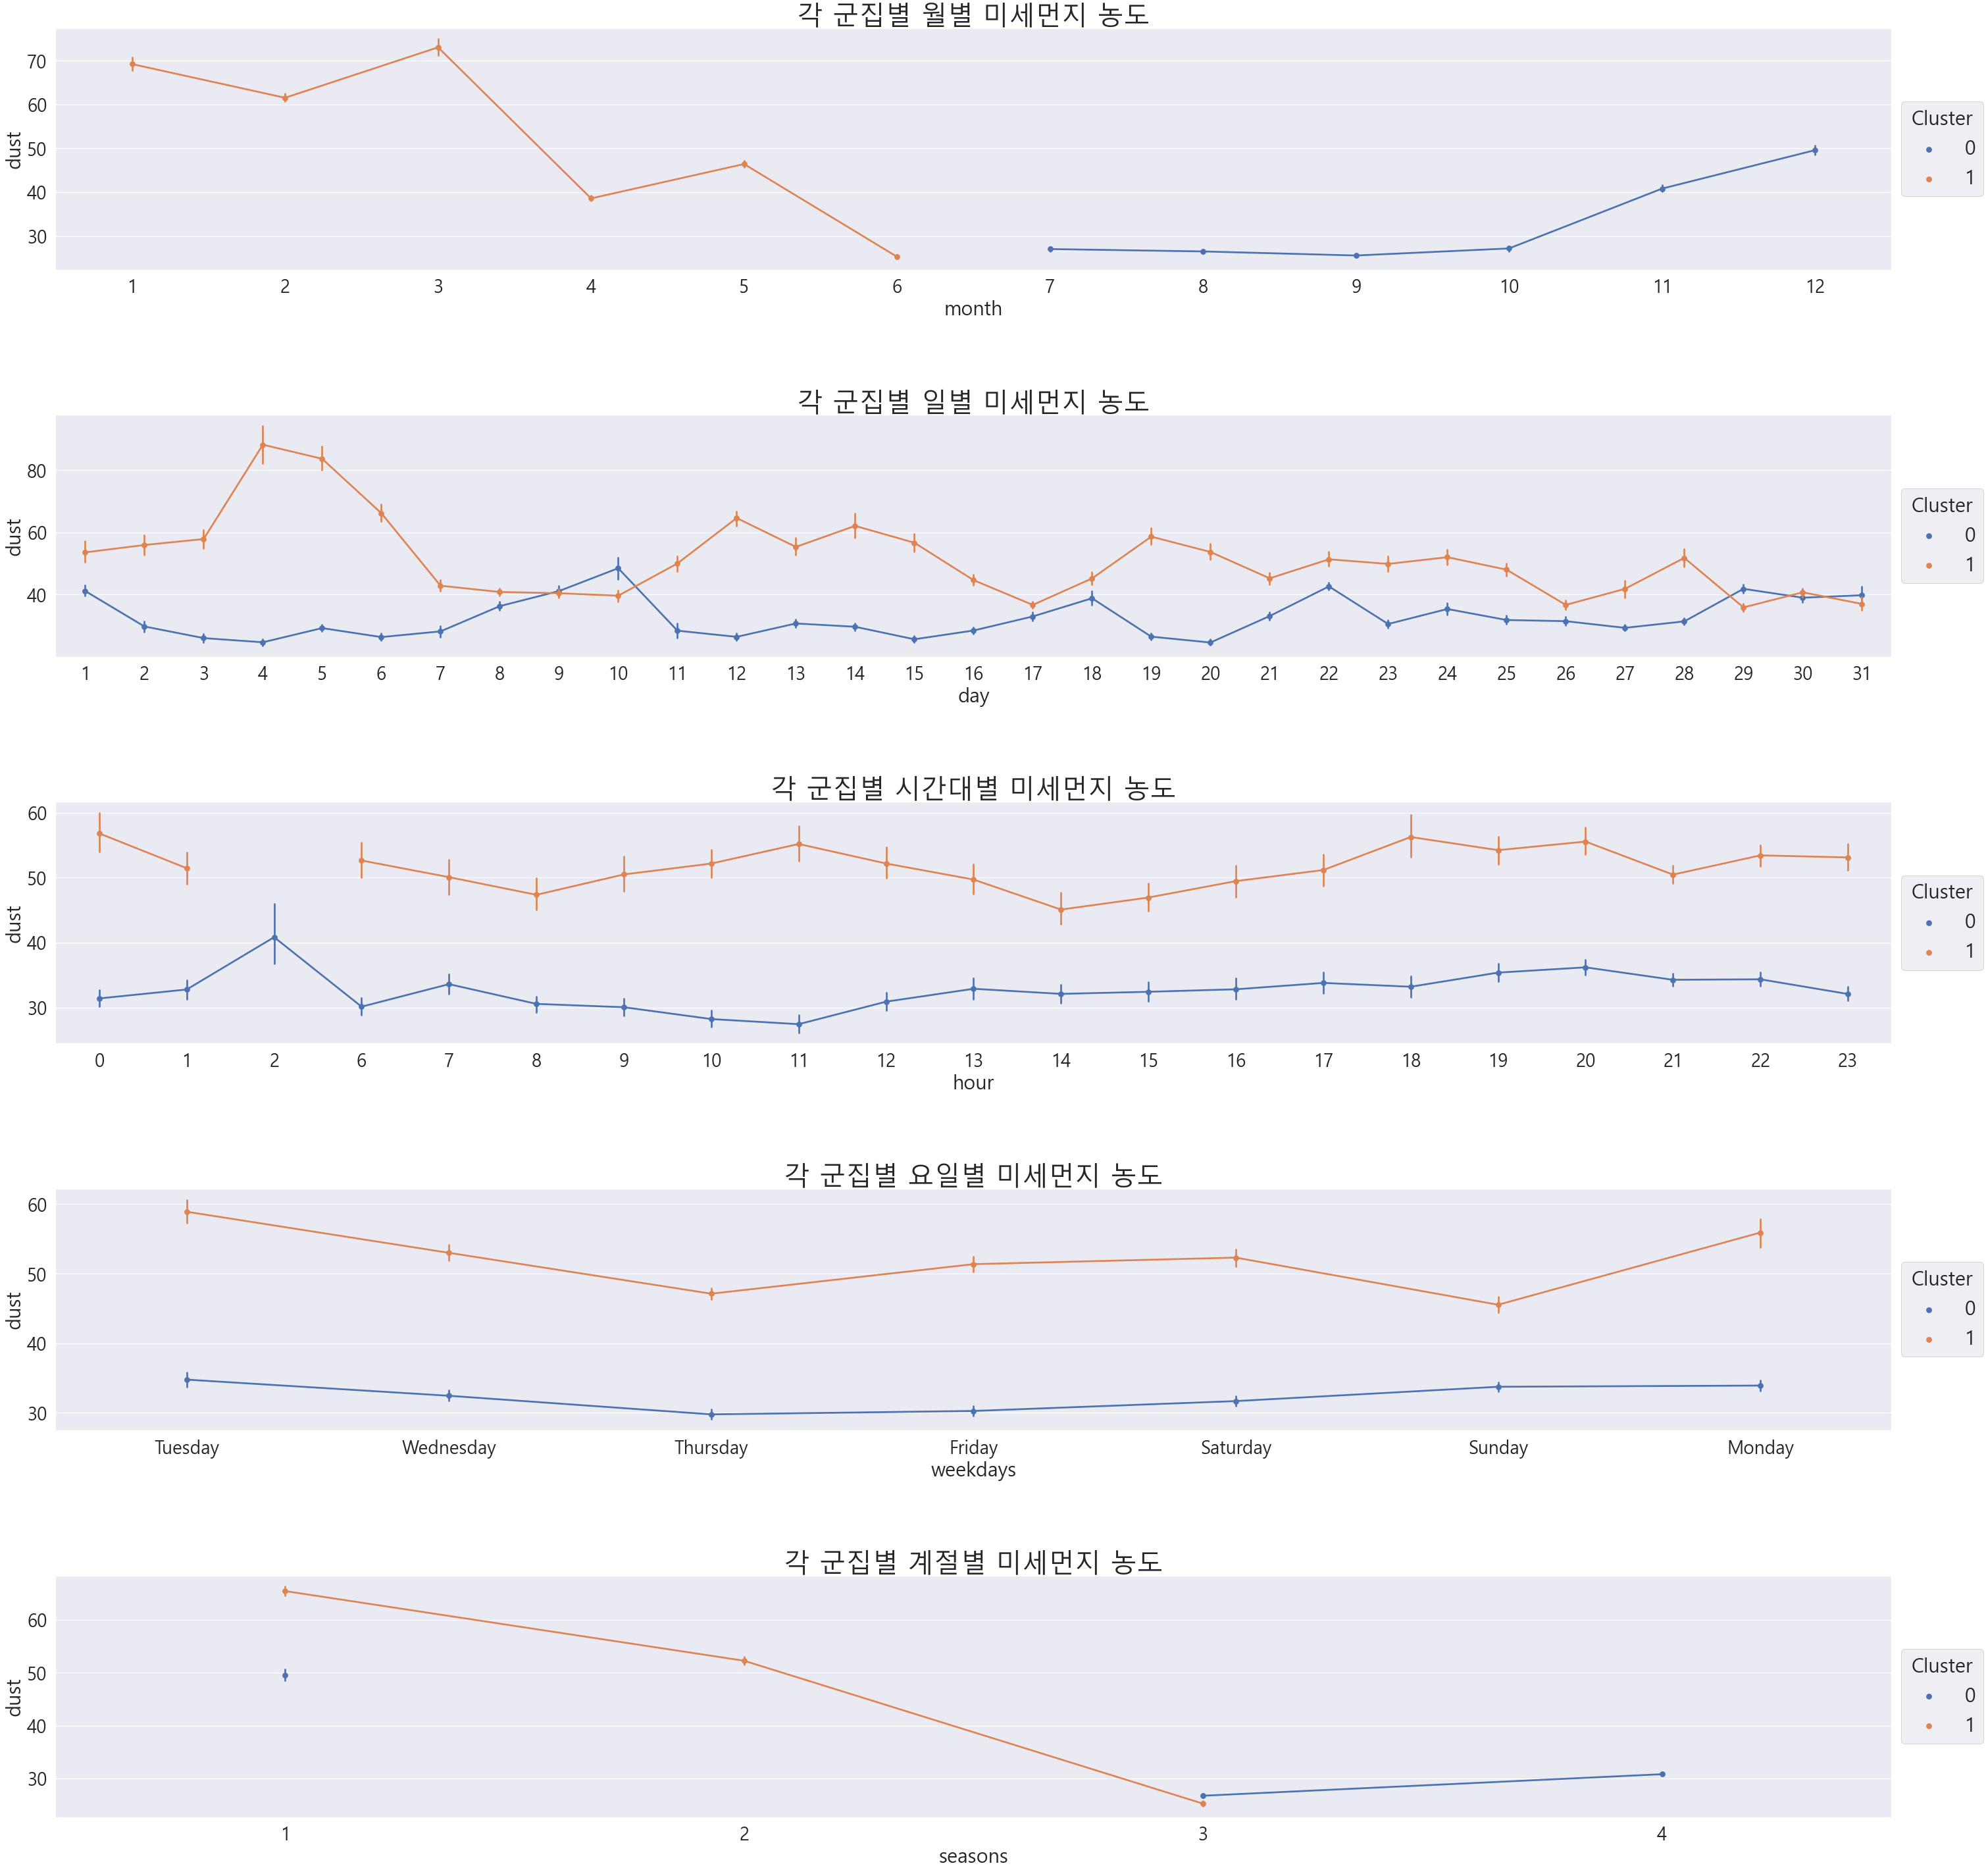

In [15]:
cluster_plots('dust', '미세먼지 농도')

- 전반적으로 판매량이 높은 군집(0)보다 판매량이 낮은 군집(1)의 미세먼지 농도가 더 높다.
    - 미세먼지 농도가 높으면 판매량도 높아질 줄 알았는데...
    - 이걸 "미세먼지 농도가 높을수록 판매량이 낮다"라고 볼 수 있나..?

## 범주형 변수
- pd_group
- is_rain
- is_snow

### 각 군집별(cluster) 상품군(pd_group)별 판매량

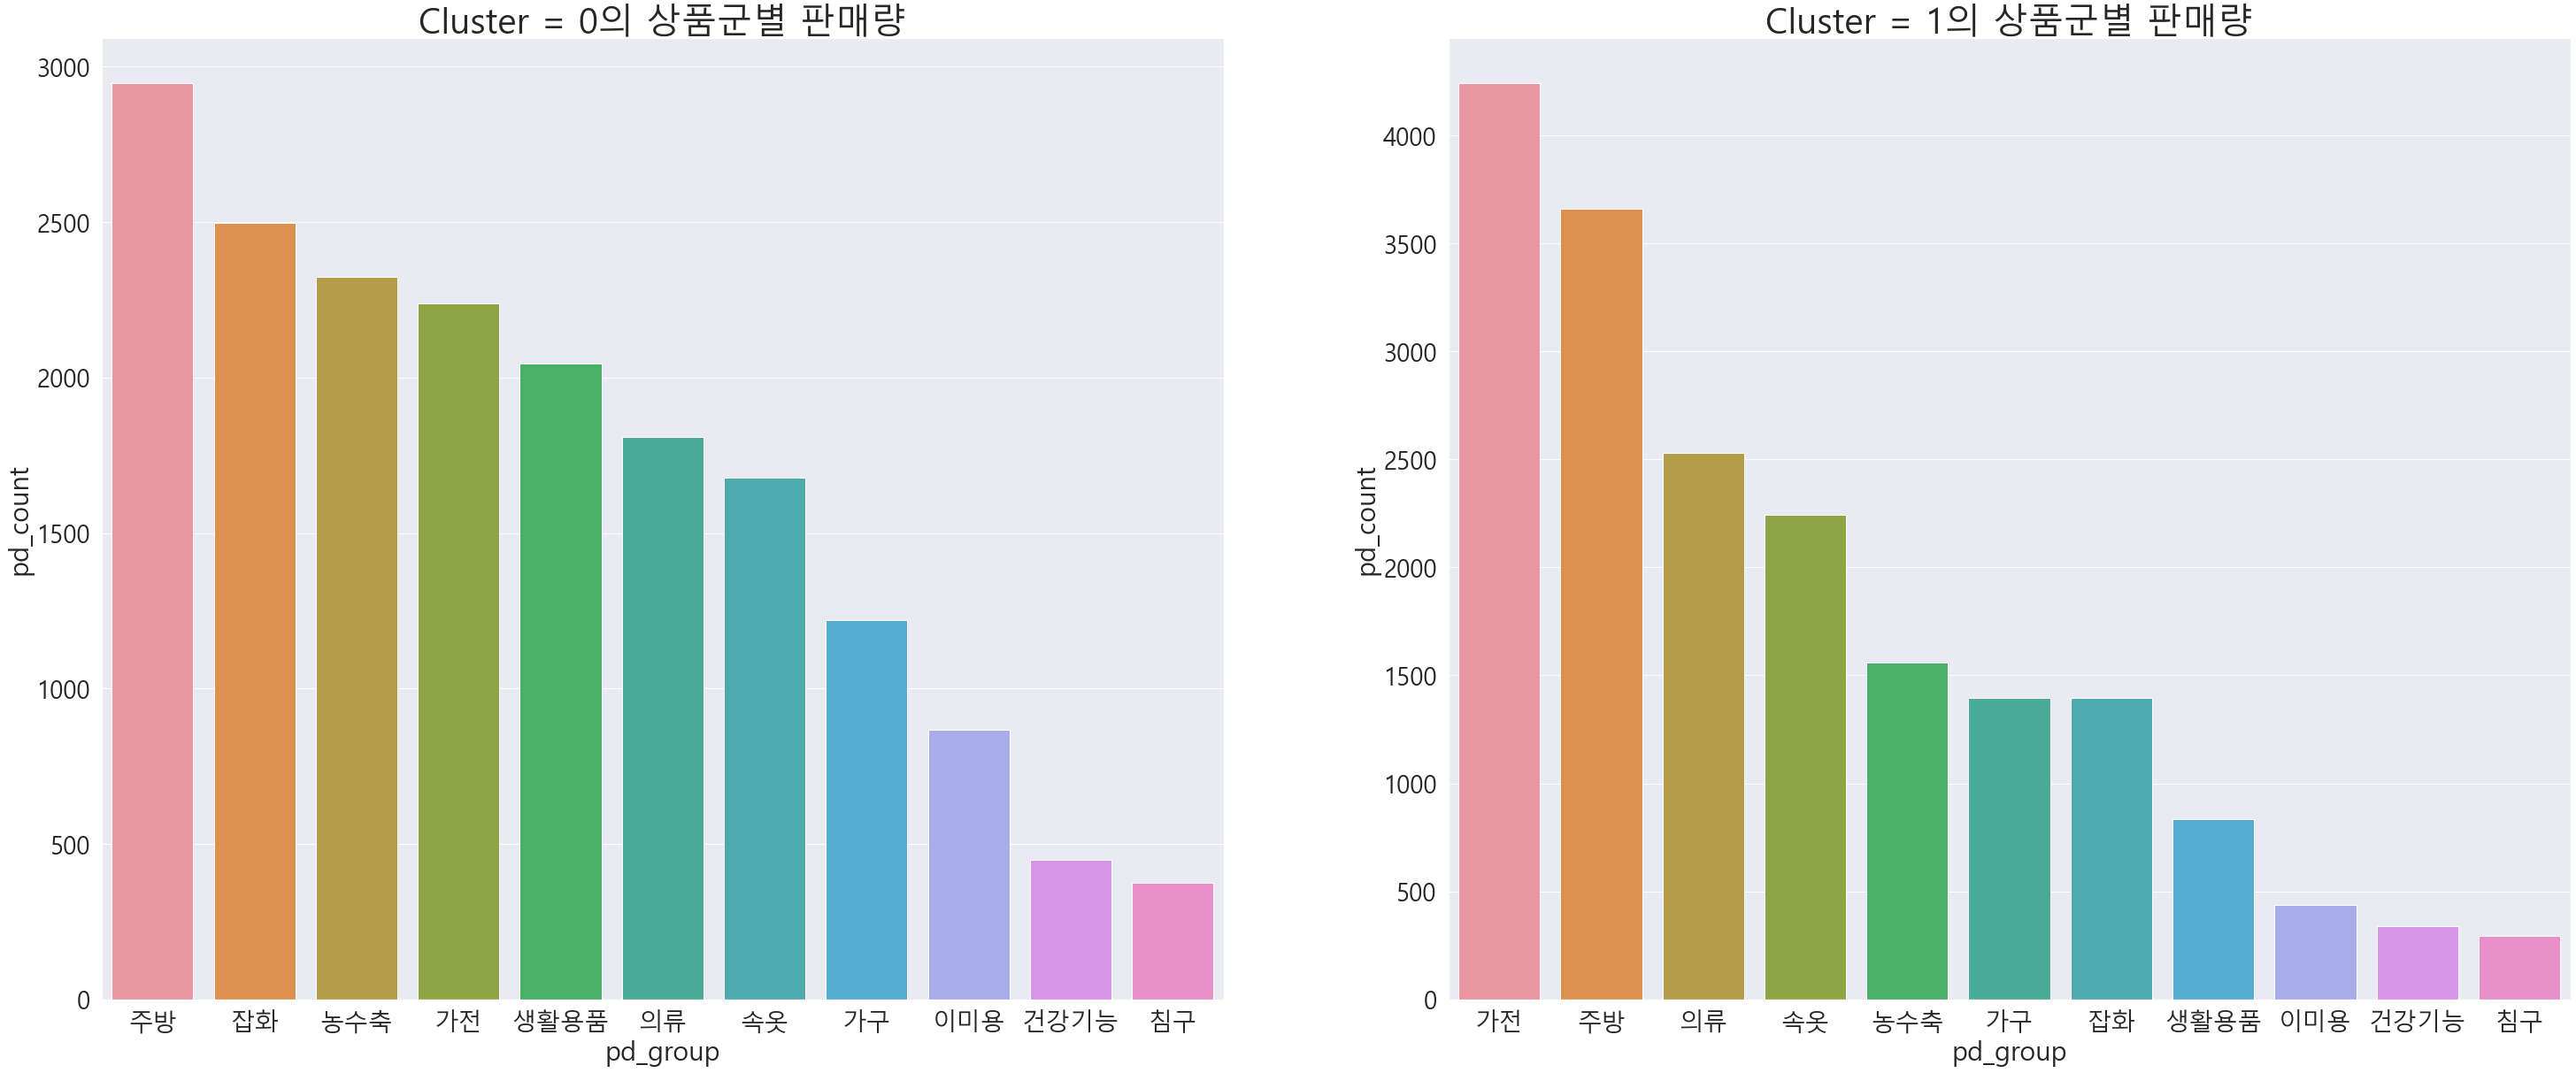

In [16]:
f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
f.set_size_inches(50, 20)

# cluster = 0인 데이터 셋
sns.countplot(data = df_cluster_0, x = 'pd_group',
              order = df_cluster_0['pd_group'].value_counts().index, ax = ax1)
# cluster = 1인 데이터 셋
sns.countplot(data = df_cluster_1, x = 'pd_group',
              order = df_cluster_1['pd_group'].value_counts().index, ax = ax2)

ax1.set_title('Cluster = 0의 상품군별 판매량', fontsize = 40)
ax2.set_title('Cluster = 1의 상품군별 판매량', fontsize = 40)

ax1.set(ylabel = 'pd_count')
ax2.set(ylabel = 'pd_count')

plt.show()

- 각 군집별로 판매량이 높은 상품군은 위와 같다.
    - 판매량이 비교적 높은 군집(0)의 경우, "주방" 상품군을 가장 많이 방송했다
    - 판매량이 비교적 낮은 군집(1)의 경우, "가전" 상품군을 가장 많이 방송했다.

### 각 군집별(cluster) 비 내림 여부(is_rain) 및 눈 내림 여부(is_snow)

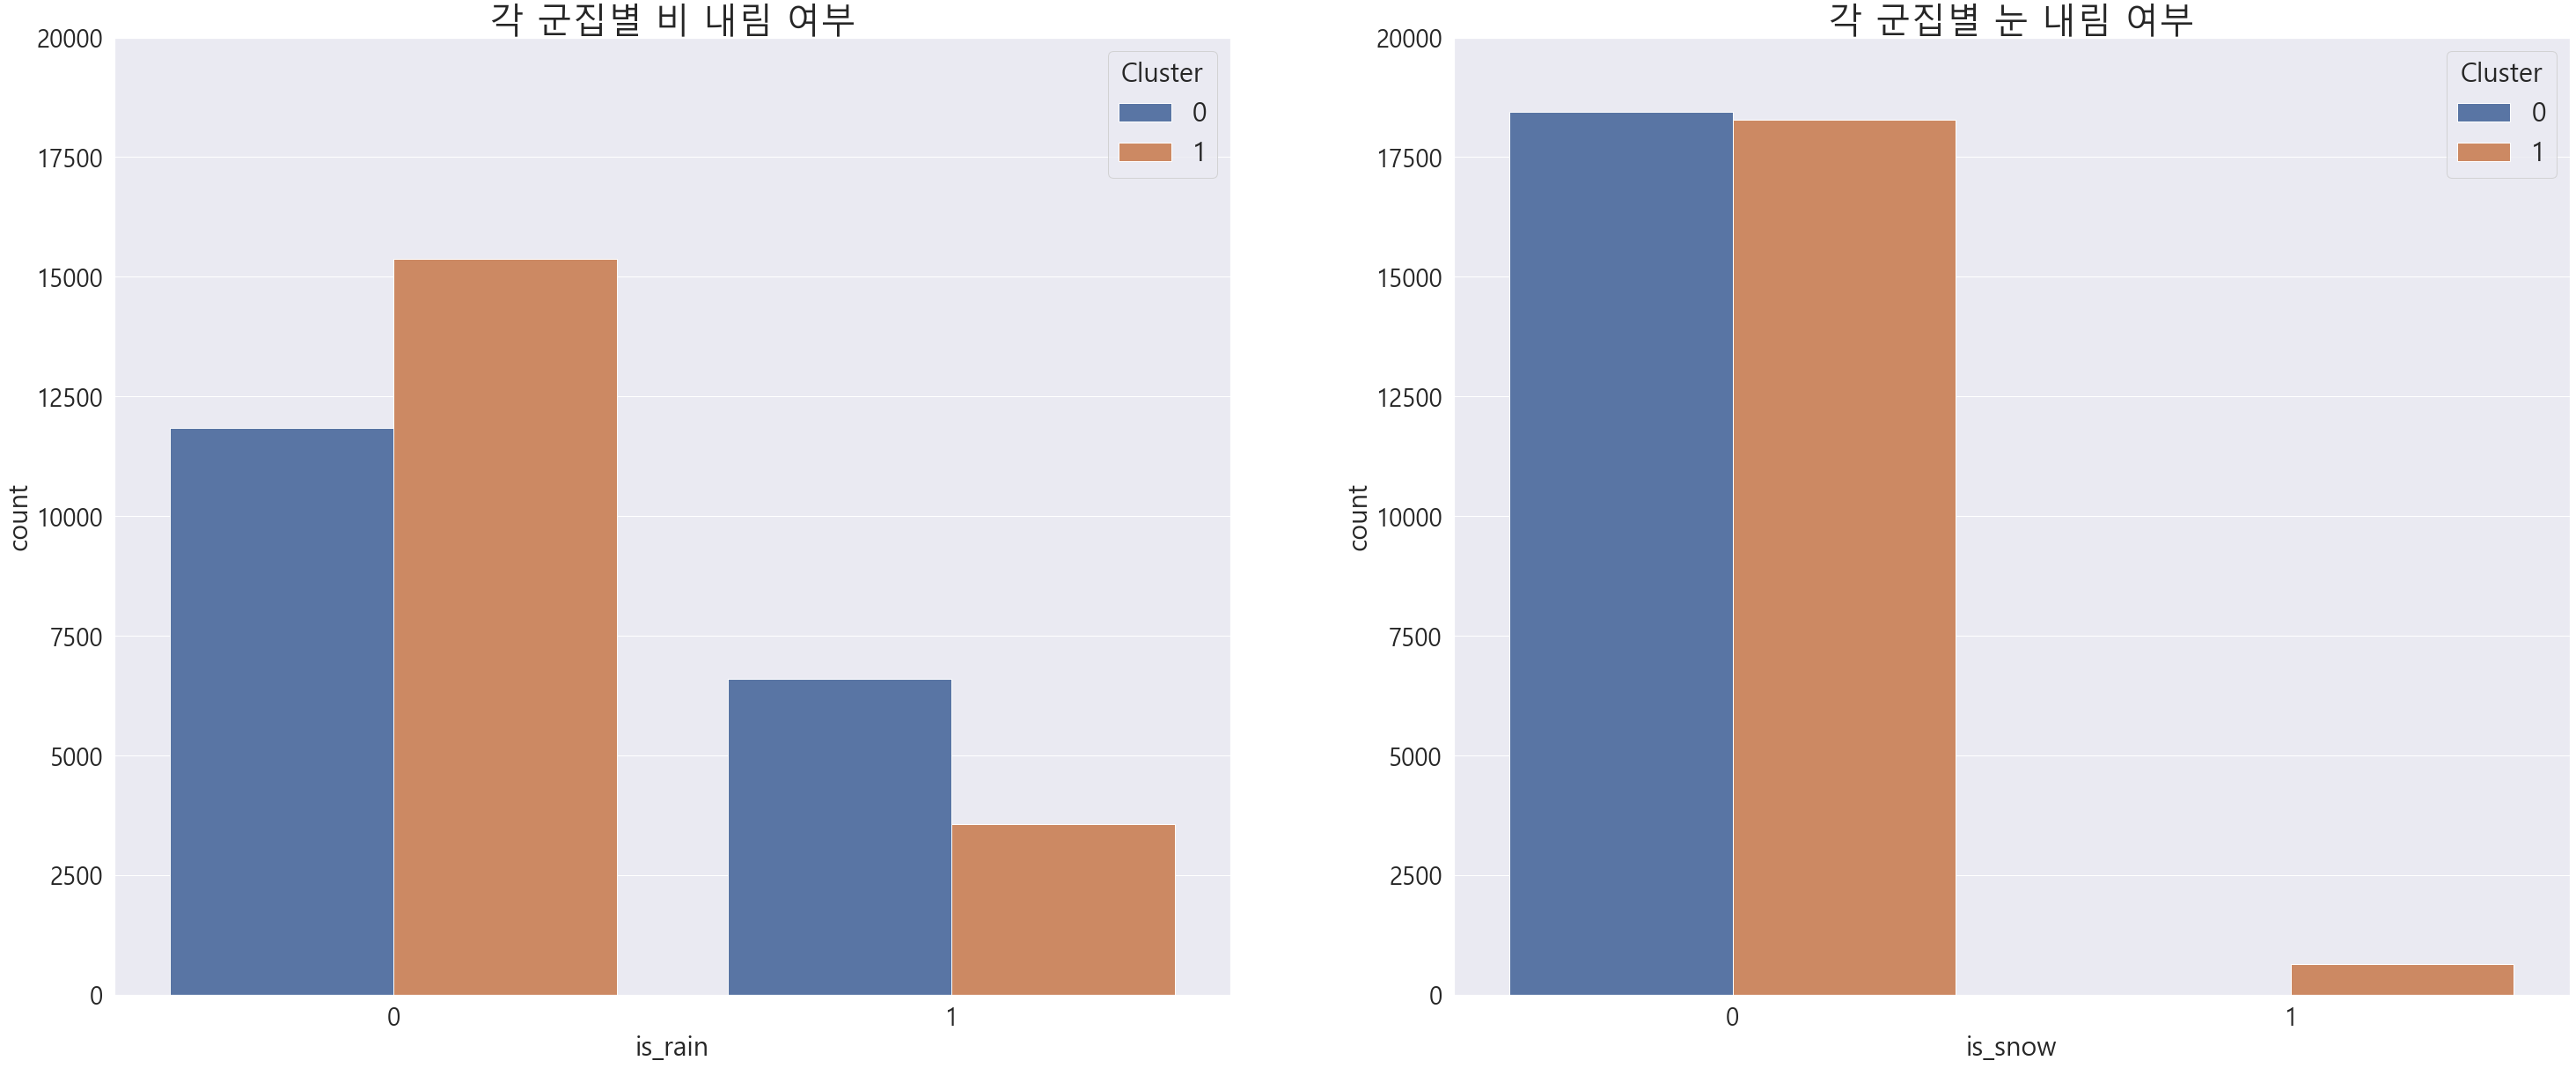

In [17]:
f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
f.set_size_inches(50, 20)

# 1. 비 내림 여부
sns.countplot(data = clustered, x = 'is_rain', hue = 'cluster', ax = ax1)
# 2. 눈 내림 여부
sns.countplot(data = clustered, x = 'is_snow', hue = 'cluster', ax = ax2)

ax1.set_title('각 군집별 비 내림 여부', fontsize = 40)
ax2.set_title('각 군집별 눈 내림 여부', fontsize = 40)

ax1.set(ylim = (0, 20000))
ax2.set(ylim = (0, 20000))

ax1.legend(title = 'Cluster', title_fontsize = 30, frameon = True, fontsize = 30)
ax2.legend(title = 'Cluster', title_fontsize = 30, frameon = True, fontsize = 30)

plt.show()

- 결과를 보면, 두 군집 모두 비 또눈 눈이 내리지 않은 날이 더 많은데 이는 당연한 결과이다.
    - 1년 중, 비 또는 눈이 내린 날이 많지 않으므로..
- 따라서 비 또는 눈이 내린 날에 대해서만 결과 해석을 해보겠다. (즉, is_rain과 is_snow 변수가 "1"에 해당하는 부분에 대해서만 분석)
    - cluster = 0 : 판매량이 비교적 적은 군집에 비해, 판매량이 비교적 높은 군집이 비가 내린 날이 많다.
    - cluster = 1 : 판매량이 비교적 높은 군집에 비해, 판매량이 비교적 낮은 군집이 눈이 내린 날이 많다.
    - 다시 말하면 **비가 내린 날이 많을수록 판매량이 비교적 높고, 눈이 내린 날이 많을수록 판매량이 비교적 낮다.**
        - 근데 왜 앞에서 상관계수는 낮게 나온거죠..?